In [2]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2
import mediapipe as mp
import pyautogui

In [3]:
# ====== Настройки ======
print(f'Vesrsion of torch: {torch.__version__}')
data_dir = '../data/split'
batch_size = 128
epochs = 20
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Vesrsion of torch: 2.7.0+cu128
cuda


In [4]:
# ====== Аугментации и трансформации ======
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# ====== Загрузка данных ======
#train_dataset = ImageFolder(os.path.join('../data', 'sample_train'), transform=train_transform)
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset   = ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transform)
test_dataset  = ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, num_workers=8)
test_loader  = DataLoader(test_dataset, batch_size=batch_size,num_workers=8)

num_classes = len(train_dataset.classes)
print(len(train_dataset.classes))
print(train_dataset.classes)

34
['call', 'dislike', 'fist', 'four', 'grabbing', 'grip', 'gun', 'hand_heart', 'hand_heart2', 'holy', 'like', 'little_finger', 'middle_finger', 'mute', 'no_gesture', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'point', 'rock', 'stop', 'stop_inverted', 'take_picture', 'three', 'three2', 'three3', 'thumb_index', 'thumb_index2', 'timeout', 'two_up', 'two_up_inverted', 'xsign']


In [6]:
# --- Подготовка случайного поднабора из 1000 примеров для валидации во время обучения ---
num_val_samples = 1000
all_indices = list(range(len(val_dataset)))
# если валидационный набор меньше 1000, возьмём весь
selected_indices = random.sample(all_indices, min(num_val_samples, len(all_indices)))
# создаём Subset и новый DataLoader
val_subset = Subset(val_dataset, selected_indices)
val_subset_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=val_loader.num_workers,
    pin_memory=True
)

## Обучаю свою простую CNN

In [26]:
# ====== Своя CNN ======
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # (B, 3, 224, 224) -> (B, 32, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(2),                # -> (B, 32, 112, 112)

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                # -> (B, 64, 56, 56)

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                # -> (B, 128, 28, 28)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)

In [27]:
# ====== Обучение ======
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/10: 100%|██████████| 1298/1298 [01:24<00:00, 15.45it/s]


Epoch 1, Loss: 2.1406


Epoch 2/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.74it/s]


Epoch 2, Loss: 2.0117


Epoch 3/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.71it/s]


Epoch 3, Loss: 1.8450


Epoch 4/10: 100%|██████████| 1298/1298 [01:24<00:00, 15.41it/s]


Epoch 4, Loss: 1.6887


Epoch 5/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.64it/s]


Epoch 5, Loss: 1.5480


Epoch 6/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.74it/s]


Epoch 6, Loss: 1.4285


Epoch 7/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.68it/s]


Epoch 7, Loss: 1.3389


Epoch 8/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.73it/s]


Epoch 8, Loss: 1.2594


Epoch 9/10: 100%|██████████| 1298/1298 [01:24<00:00, 15.33it/s]


Epoch 9, Loss: 1.1973


Epoch 10/10: 100%|██████████| 1298/1298 [01:24<00:00, 15.40it/s]

Epoch 10, Loss: 1.1238


In [28]:
# ====== Оценка ======
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# ====== Сохранение ======
torch.save(model.state_dict(), "custom_gesture_model.pth")


Classification Report:
              precision    recall  f1-score   support

     dislike       0.74      0.76      0.75      4745
        fist       0.55      0.61      0.58      4732
        like       0.57      0.62      0.60      4688
        mute       0.77      0.76      0.77      4853
  no_gesture       0.33      0.48      0.39       326
          ok       0.62      0.44      0.51      4674
         one       0.53      0.65      0.58      4782
        palm       0.67      0.64      0.66      4757
        stop       0.57      0.48      0.52      4691

    accuracy                           0.62     38248
   macro avg       0.60      0.61      0.60     38248
weighted avg       0.63      0.62      0.62     38248



## Обучаю resnet

In [ ]:
# ====== Загрузка предобученной ResNet18 и изменение последнего слоя ======
resnet_model = models.resnet18(pretrained=True)

# Для заморозки всех слоёв кроме последнего:
# for param in resnet_model.parameters():
#     param.requires_grad = False

resnet_model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout перед классификацией
    nn.Linear(resnet_model.fc.in_features, num_classes) 
)


resnet_model = resnet_model.to(device)

In [11]:
num_classes

34

In [12]:
# ====== Настройка обучения ======
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=lr)
train_losses = []
val_losses = []


In [13]:
# ====== Цикл обучения ======
for epoch in range(epochs):
    resnet_model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # --- Валидационная фаза ---
    resnet_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_subset_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_subset_loader)
    val_losses.append(avg_val_loss)


    print(f"Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/20: 100%|██████████| 5941/5941 [22:51<00:00,  4.33it/s]


Train Loss: 0.3826, Val Loss: 0.2189


Epoch 2/20: 100%|██████████| 5941/5941 [22:27<00:00,  4.41it/s]


Train Loss: 0.2030, Val Loss: 0.1631


Epoch 3/20: 100%|██████████| 5941/5941 [22:50<00:00,  4.33it/s]


Train Loss: 0.1597, Val Loss: 0.1417


Epoch 4/20: 100%|██████████| 5941/5941 [22:42<00:00,  4.36it/s]


Train Loss: 0.1349, Val Loss: 0.1690


Epoch 5/20: 100%|██████████| 5941/5941 [23:02<00:00,  4.30it/s]


Train Loss: 0.1187, Val Loss: 0.1104


Epoch 6/20: 100%|██████████| 5941/5941 [23:03<00:00,  4.29it/s]


Train Loss: 0.1070, Val Loss: 0.0986


Epoch 7/20: 100%|██████████| 5941/5941 [22:59<00:00,  4.31it/s]


Train Loss: 0.0981, Val Loss: 0.0703


Epoch 8/20: 100%|██████████| 5941/5941 [23:01<00:00,  4.30it/s]


Train Loss: 0.0896, Val Loss: 0.0873


Epoch 9/20: 100%|██████████| 5941/5941 [23:08<00:00,  4.28it/s]


Train Loss: 0.0834, Val Loss: 0.1247


Epoch 10/20: 100%|██████████| 5941/5941 [22:58<00:00,  4.31it/s]


Train Loss: 0.0789, Val Loss: 0.0796


Epoch 11/20: 100%|██████████| 5941/5941 [22:59<00:00,  4.31it/s]


Train Loss: 0.0738, Val Loss: 0.0777


Epoch 12/20: 100%|██████████| 5941/5941 [23:03<00:00,  4.30it/s]


Train Loss: 0.0704, Val Loss: 0.0650


Epoch 13/20: 100%|██████████| 5941/5941 [23:00<00:00,  4.30it/s]


Train Loss: 0.0668, Val Loss: 0.0650


Epoch 14/20: 100%|██████████| 5941/5941 [23:08<00:00,  4.28it/s]


Train Loss: 0.0631, Val Loss: 0.0887


Epoch 15/20: 100%|██████████| 5941/5941 [23:03<00:00,  4.29it/s]


Train Loss: 0.0610, Val Loss: 0.0755


Epoch 16/20: 100%|██████████| 5941/5941 [23:03<00:00,  4.30it/s]


Train Loss: 0.0572, Val Loss: 0.0514


Epoch 17/20: 100%|██████████| 5941/5941 [23:02<00:00,  4.30it/s]


Train Loss: 0.0561, Val Loss: 0.0677


Epoch 18/20: 100%|██████████| 5941/5941 [23:02<00:00,  4.30it/s]


Train Loss: 0.0532, Val Loss: 0.0409


Epoch 19/20: 100%|██████████| 5941/5941 [22:59<00:00,  4.31it/s]


Train Loss: 0.0512, Val Loss: 0.0749


Epoch 20/20: 100%|██████████| 5941/5941 [23:05<00:00,  4.29it/s]


Train Loss: 0.0494, Val Loss: 0.0496


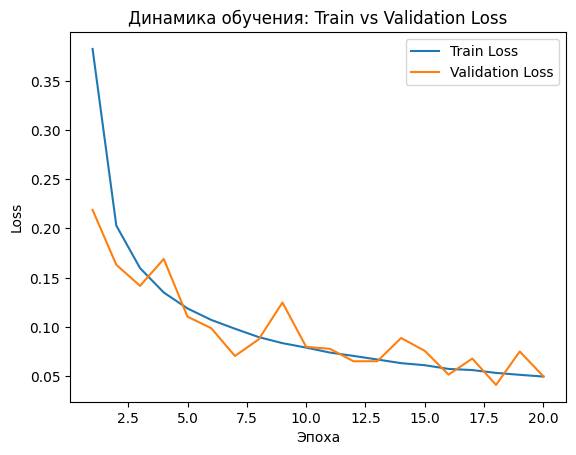

In [16]:
# --- Построение графика ---
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses,   label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Динамика обучения: Train vs Validation Loss')
plt.legend()
plt.show()

In [31]:
# ====== Оценка ======
resnet_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = resnet_model(images)
        preds = outputs.argmax(dim=1).cpu()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))


Classification Report:
                 precision    recall  f1-score   support

           call       0.98      0.98      0.98      4209
        dislike       0.98      0.99      0.99      4743
           fist       0.97      0.97      0.97      4731
           four       0.97      0.96      0.97      4715
       grabbing       0.98      0.99      0.99      5452
           grip       1.00      0.99      0.99      5460
            gun       0.99      0.99      0.99      5631
     hand_heart       1.00      0.99      1.00      4436
    hand_heart2       1.00      1.00      1.00      4797
           holy       1.00      1.00      1.00      5910
           like       0.96      0.97      0.96      4686
  little_finger       0.99      0.99      0.99      5445
  middle_finger       0.98      0.99      0.99      5705
           mute       0.99      0.99      0.99      4852
     no_gesture       0.97      0.88      0.92       324
             ok       0.98      0.98      0.98      4672
      

In [17]:
#====== Сохранение ======
torch.save(resnet_model.state_dict(), "trained_res18_full_train_all_gestures.pth")

## Проба прода

In [45]:
# ——— Настройка модели ———
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(weights=None)

model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.fc.in_features, num_classes)
)

model.load_state_dict(torch.load('trained_res18_full_train_all_gestures.pth'))
model.to(device).eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [46]:
# ——— Настройка MediaPipe ———
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.85,
    min_tracking_confidence=0.85
)
mp_draw = mp.solutions.drawing_utils

In [47]:
# thresholds
TH_X, TH_Y = 40, 40

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Ошибка: не удалось открыть видеофайл.")


In [49]:
import collections
import pyautogui
import cv2
import numpy as np
import torch
import time
from collections import deque, Counter

# ——— Настройки ———
N_FRAMES = 10  # Количество кадров для усреднения предсказаний
CONF_THRESHOLD = 0.8  # Порог уверенности классификации
TH_X, TH_Y = 5, 5  # Пороговые значения движения по x и y
SMOOTH_THRESHOLD = 5  # Минимальное смещение для обработки

# Кулдауны (время блокировки между повторными действиями)
activation_cooldown = 4.0
action_cooldown = 3.0
move_action_cooldown = 0.2
thumb_index_cooldown = 0.1
strong_move_action_cooldown = 0.6

# Буферы и состояния
gesture_buffer = deque(maxlen=N_FRAMES)  # Буфер последних N жестов
tracking = False  # Включен ли трекинг движения
activated = False  # Включён ли режим управления
start_pos = None  # Стартовая позиция движения
active_gesture = None  # Текущий активный жест для трекинга

# Таймеры для кулдаунов
timers = {
    'activation': 0,     # Таймер на включение/выключение режима
    'action': 0,         # Таймер на одиночные действия
    'move': 0,           # Таймер на плавные движения (перемотка/громкость)
    'strong_move': 0,    # Таймер на "сильные" движения (много нажатий)
}

# Словарь действий для жестов
gesture_actions = {
    # Жесты-одиночные действия
    'like': {'type': 'press', 'key': 'l', 'cooldown': action_cooldown, 'timer': 'action', 'presses': 1},
    'dislike': {'type': 'press', 'key': 'd', 'cooldown': action_cooldown, 'timer': 'action', 'presses': 1},
    'stop': {'type': 'press', 'key': 'space', 'cooldown': action_cooldown, 'timer': 'action', 'presses': 1},
    'gun': {'type': 'press', 'key': 'n', 'cooldown': action_cooldown, 'timer': 'action', 'presses': 1},
    'two_up': {'type': 'press', 'key': 'right', 'cooldown': strong_move_action_cooldown, 'timer': 'strong_move', 'presses': 3},
    'two_up_inverted': {'type': 'press', 'key': 'left', 'cooldown': strong_move_action_cooldown, 'timer': 'strong_move', 'presses': 3},
    
    # Плавные движения (перемотка и громкость)
    'palm_right': {'type': 'move', 'key': 'right', 'cooldown': move_action_cooldown, 'timer': 'move'},
    'palm_left': {'type': 'move', 'key': 'left', 'cooldown': move_action_cooldown, 'timer': 'move'},
    'grabbing_right': {'type': 'move', 'key': 'right', 'cooldown': move_action_cooldown, 'timer': 'move'},
    'grabbing_left': {'type': 'move', 'key': 'left', 'cooldown': move_action_cooldown, 'timer': 'move'},
    'thumb_index_up': {'type': 'move', 'key': 'volumeup', 'cooldown': thumb_index_cooldown, 'timer': 'move'},
    'thumb_index_down': {'type': 'move', 'key': 'volumedown', 'cooldown': thumb_index_cooldown, 'timer': 'move'},
}


In [ ]:
# ——— Главный цикл обработки кадров ———
while True:
    ret, frame = cap.read()
    if not ret:
        break

    current_time = time.time()

    # — 1. Классификация кадра —
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(pil)
        probs = torch.softmax(out, dim=1)
        confidence, cls = probs.max(1)
        if confidence.item() < CONF_THRESHOLD:
            gesture = 'no_gesture'
        else:
            gesture = train_dataset.classes[cls.item()]

    gesture_buffer.append(gesture)

    # — Мажоритарное голосование по буферу жестов —
    if len(gesture_buffer) == N_FRAMES:
        most_common_gesture, count = Counter(gesture_buffer).most_common(1)[0]
    else:
        most_common_gesture = 'no_gesture'

    # — 2. Детекция ключевых точек (пальцев) —
    res = hands.process(img)
    if res.multi_hand_landmarks:
        lm = res.multi_hand_landmarks[0].landmark
        coords = np.array([[int(pt.x * frame.shape[1]), int(pt.y * frame.shape[0])] for pt in lm])

        # Рисуем все найденные точки
        for coord in coords:
            cv2.circle(frame, tuple(coord), 5, (0, 255, 0), -1)

        # Вычисляем центр ладони
        center = coords.mean(axis=0).astype(int)
        cv2.circle(frame, tuple(center), 5, (0, 255, 0), -1)

        # Дополнительная проверка ориентации большого пальца
        thumb_tip = coords[4]
        index_tip = coords[8]
        if most_common_gesture == 'like' and not (thumb_tip[1] < index_tip[1]):
            most_common_gesture = 'no_gesture'
        if most_common_gesture == 'dislike' and not (thumb_tip[1] > index_tip[1]):
            most_common_gesture = 'no_gesture'
    else:
        center = None

    # — 3. Обработка жеста активации режима —
    if most_common_gesture == 'timeout' and (current_time - timers['activation']) > activation_cooldown:
        activated = not activated
        print(f'Режим {"активирован" if activated else "деактивирован"}')
        timers['activation'] = current_time
        gesture_buffer.clear()
        continue

    # — 4. Обработка трекинга движения —
    if activated and center is not None and most_common_gesture in ('palm', 'grabbing', 'thumb_index'):
        if not tracking or most_common_gesture != active_gesture:
            # Запуск нового трекинга
            tracking = True
            active_gesture = most_common_gesture
            last_center = center.copy()
        else:
            # Вычисление смещения
            move_dx, move_dy = center - last_center
            move_dist = np.linalg.norm([move_dx, move_dy])

            if move_dist < SMOOTH_THRESHOLD:
                continue
            if move_dist > 50:
                print("Резкий скачок — трекинг сброшен")
                tracking = False
                active_gesture = None
                continue

            # Определение направления движения
            gesture_key = None
            if most_common_gesture in ('palm', 'grabbing'):
                if abs(move_dx) > TH_X:
                    gesture_key = f'{most_common_gesture}_right' if move_dx > 0 else f'{most_common_gesture}_left'
            elif most_common_gesture == 'thumb_index':
                if abs(move_dy) > TH_Y:
                    gesture_key = 'thumb_index_up' if move_dy < 0 else 'thumb_index_down'

            # Выполнение действия по движению
            if gesture_key and gesture_key in gesture_actions:
                action = gesture_actions[gesture_key]
                cooldown = action['cooldown']
                timer_name = action['timer']
                if (current_time - timers[timer_name]) > cooldown:
                    pyautogui.press(action['key'])
                    timers[timer_name] = current_time

            last_center = center.copy()
    else:
        tracking = False
        active_gesture = None

    # — 5. Выполнение одиночных действий по жестам —
    if activated and most_common_gesture in gesture_actions:
        action = gesture_actions[most_common_gesture]
        cooldown = action['cooldown']
        timer_name = action['timer']
        if (current_time - timers[timer_name]) > cooldown:
            pyautogui.press(action['key'], presses=action.get('presses', 1), interval=0)
            timers[timer_name] = current_time
            if timer_name == 'action':
                gesture_buffer.clear()

    # — 6. Отображение статуса на экране —
    status_text = f"Gesture: {most_common_gesture} | {'Active' if activated else 'Inactive'}"
    cv2.putText(frame, status_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    cv2.imshow("Gestures", frame)

    if cv2.waitKey(1) == ord('q'):
        break

# ——— Очистка ресурсов ———
cap.release()
cv2.destroyAllWindows()

Режим активирован
Резкий скачок — трекинг сброшен
Резкий скачок — трекинг сброшен
Режим деактивирован


In [ ]:
import cv2
import torch
import numpy as np
import pyautogui
import time
from collections import deque, Counter
import mediapipe as mp
from torchvision import models, transforms
import torch.nn as nn


class GestureModel:
    def __init__(self, model_path, num_classes, class_names):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = models.resnet18(weights=None)
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device).eval()
        self.class_names = class_names
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def predict(self, frame):
        print("[DEBUG] Исходная форма кадра:", frame.shape)
        
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        print("[DEBUG] Преобразован в RGB. Проверка первого пикселя BGR vs RGB:", frame[0, 0], "->", img[0, 0])

        tensor = self.transform(img).unsqueeze(0).to(self.device)
        print("[DEBUG] Tensor shape:", tensor.shape)
        print("[DEBUG] Tensor dtype:", tensor.dtype)
        print("[DEBUG] Tensor min/max:", tensor.min().item(), "/", tensor.max().item())

        with torch.no_grad():
            output = self.model(tensor)
            probs = torch.softmax(output, dim=1)
            confidence, cls = probs.max(1)

        predicted_class = self.class_names[cls.item()]
        print(f"[DEBUG] Предсказано: {predicted_class} (уверенность: {confidence.item():.3f})")

        if confidence.item() > 0.2:
            return predicted_class
        else:
            print("[DEBUG] Уверенность слишком низкая, возвращается 'no_gesture'")
            return 'no_gesture'


class HandTracker:
    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.85,
            min_tracking_confidence=0.85
        )
        self.mp_draw = mp.solutions.drawing_utils

    def process(self, frame):
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.hands.process(rgb)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                self.mp_draw.draw_landmarks(frame, hand_landmarks, self.mp_hands.HAND_CONNECTIONS)
            landmarks = results.multi_hand_landmarks[0].landmark
            coords = np.array([[int(pt.x * frame.shape[1]), int(pt.y * frame.shape[0])] for pt in landmarks])
            center = coords.mean(axis=0).astype(int)
            return coords, center
        return None, None


class GestureController:
    def __init__(self):
        self.N_FRAMES = 10
        self.buffer = deque(maxlen=self.N_FRAMES)
        self.activated = False
        self.tracking = False
        self.active_gesture = None
        self.start_center = None
        self.last_center = None

        self.timers = {
            'activation': 0,
            'action': 0,
            'move': 0,
            'strong_move': 0,
        }

        self.TH_X, self.TH_Y = 5, 5
        self.SMOOTH_THRESHOLD = 5
        self.gesture_actions = {
            'like': {'type': 'press', 'key': 'l', 'cooldown': 3.0, 'timer': 'action', 'presses': 1},
            'dislike': {'type': 'press', 'key': 'd', 'cooldown': 3.0, 'timer': 'action', 'presses': 1},
            'stop': {'type': 'press', 'key': 'space', 'cooldown': 3.0, 'timer': 'action', 'presses': 1},
            'gun': {'type': 'press', 'key': 'n', 'cooldown': 3.0, 'timer': 'action', 'presses': 1},
            'two_up': {'type': 'press', 'key': 'right', 'cooldown': 0.6, 'timer': 'strong_move', 'presses': 3},
            'two_up_inverted': {'type': 'press', 'key': 'left', 'cooldown': 0.6, 'timer': 'strong_move', 'presses': 3},
            'palm_right': {'type': 'move', 'key': 'right', 'cooldown': 0.2, 'timer': 'move'},
            'palm_left': {'type': 'move', 'key': 'left', 'cooldown': 0.2, 'timer': 'move'},
            'grabbing_right': {'type': 'move', 'key': 'right', 'cooldown': 0.2, 'timer': 'move'},
            'grabbing_left': {'type': 'move', 'key': 'left', 'cooldown': 0.2, 'timer': 'move'},
            'thumb_index_up': {'type': 'move', 'key': 'volumeup', 'cooldown': 0.1, 'timer': 'move'},
            'thumb_index_down': {'type': 'move', 'key': 'volumedown', 'cooldown': 0.1, 'timer': 'move'},
        }

    def update_gesture(self, gesture):
        self.buffer.append(gesture)

    def get_majority_gesture(self):
        if len(self.buffer) == self.N_FRAMES:
            return Counter(self.buffer).most_common(1)[0][0]
        return 'no_gesture'

    def toggle_activation(self, current_time):
        if current_time - self.timers['activation'] > 4.0:
            self.activated = not self.activated
            self.timers['activation'] = current_time
            self.buffer.clear()
            print(f"Режим {'активирован' if self.activated else 'деактивирован'}")
            return True
        return False

    def handle_action(self, gesture, current_time):
        if not self.activated or gesture not in self.gesture_actions:
            return
        action = self.gesture_actions[gesture]
        if (current_time - self.timers[action['timer']]) > action['cooldown']:
            pyautogui.press(action['key'], presses=action.get('presses', 1))
            self.timers[action['timer']] = current_time
            if action['timer'] == 'action':
                self.buffer.clear()

    def handle_tracking(self, gesture, center, current_time):
        if not self.activated or center is None:
            self.tracking = False
            self.active_gesture = None
            return

        if gesture not in ('palm', 'grabbing', 'thumb_index'):
            self.tracking = False
            self.active_gesture = None
            return

        if not self.tracking or gesture != self.active_gesture:
            self.tracking = True
            self.active_gesture = gesture
            self.last_center = center.copy()
            return

        dx, dy = center - self.last_center
        if np.linalg.norm([dx, dy]) < self.SMOOTH_THRESHOLD:
            return

        gesture_key = None
        if gesture in ('palm', 'grabbing'):
            if abs(dx) > self.TH_X:
                gesture_key = f"{gesture}_{'right' if dx > 0 else 'left'}"
        elif gesture == 'thumb_index':
            if abs(dy) > self.TH_Y:
                gesture_key = 'thumb_index_up' if dy < 0 else 'thumb_index_down'

        if gesture_key and gesture_key in self.gesture_actions:
            action = self.gesture_actions[gesture_key]
            if (current_time - self.timers[action['timer']]) > action['cooldown']:
                pyautogui.press(action['key'])
                self.timers[action['timer']] = current_time

        self.last_center = center.copy()


class GestureApp:
    def __init__(self, model_path, num_classes, class_names):
        self.model = GestureModel(model_path, num_classes, class_names)
        self.tracker = HandTracker()
        self.controller = GestureController()
        self.cap = cv2.VideoCapture(0)

    def run(self):
        if not self.cap.isOpened():
            print("Ошибка: не удалось открыть камеру.")
            return

        while True:
            ret, frame = self.cap.read()
            if not ret:
                break

            current_time = time.time()
            coords, center = self.tracker.process(frame)

            # Предсказываем жест только если рука найдена
            if center is not None:
                gesture = self.model.predict(frame)
                print("[DEBUG] Center:", center)
                print("[DEBUG] Gesture raw prediction:", gesture)
            else:
                gesture = 'no_gesture'

            self.controller.update_gesture(gesture)
            majority_gesture = self.controller.get_majority_gesture()
            print("[DEBUG] Majority gesture:", majority_gesture)

            # Обработка активации
            if majority_gesture == 'timeout':
                if self.controller.toggle_activation(current_time):
                    continue

            # Обработка трекинга
            self.controller.handle_tracking(majority_gesture, center, current_time)

            # Обработка одиночных действий
            self.controller.handle_action(majority_gesture, current_time)

            # Отображение центра
            if center is not None:
                cv2.circle(frame, tuple(center), 5, (0, 255, 0), -1)

            # Информационный текст
            status = f"Gesture: {majority_gesture} | {'Active' if self.controller.activated else 'Inactive'}"
            cv2.putText(frame, status, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
            cv2.putText(frame, "Press 'q' to quit", (10, frame.shape[0] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (150, 150, 150), 1)

            cv2.imshow("Gestures", frame)

            if cv2.waitKey(1) == ord('q'):
                break

            time.sleep(0.01)  # Ограничение FPS

        self.cap.release()
        cv2.destroyAllWindows()

# Пример вызова
if __name__ == "__main__":
    class_names = ['call', 'dislike', 'fist', 'four', 'grabbing', 'grip', 'gun', 'hand_heart',
                   'hand_heart2', 'holy', 'like', 'little_finger', 'middle_finger', 'mute', 'no_gesture', 'ok', 'one',
                   'palm', 'peace', 'peace_inverted', 'point', 'rock', 'stop', 'stop_inverted', 'take_picture',
                   'three', 'three2', 'three3', 'thumb_index', 'thumb_index2', 'timeout', 'two_up',
                   'two_up_inverted', 'xsign']
    app = GestureApp("trained_res18_full_train_all_gestures.pth", num_classes=len(class_names), class_names=class_names)
    app.run()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

TODO: (DONE)
1. Жест, который будет давать программе знак, что пора применять другие жесты или наоборот прекратить их применение
2. Закинуть ненужные жесты в No_gestures
3. Прекратить использовать Ok, так как он путается с пальцем вверх (one)
4. Прекратить использовать fist, так как он путается с one
5. После всего этого переобучить модель

TODO: (DONE)
1. Сильная перемотка не работает адекватно

In [ ]:
# dummy input: например, (1, 3, 224, 224) если у тебя обычные RGB кадры
dummy_input = torch.randn(1, 3, 224, 224).to(device)
torch.onnx.export(model, dummy_input, "model.onnx", input_names=['input'], output_names=['output'])

In [49]:
from onnxruntime.quantization import quantize_dynamic, QuantType

# Исходная и квантованная модели
model_fp32 = 'model.onnx'
model_quant = 'model_quant.onnx'

quantize_dynamic(
    model_input=model_fp32,
    model_output=model_quant,
    weight_type=QuantType.QInt8  # INT8 веса
)

In [66]:
# --- Подготовка случайного поднабора из 1000 примеров для валидации во время обучения ---
num_val_samples = 1000
all_indices = list(range(len(val_dataset)))
# если валидационный набор меньше 1000, возьмём весь
selected_indices = random.sample(all_indices, min(num_val_samples, len(all_indices)))
# создаём Subset и новый DataLoader
val_subset = Subset(val_dataset, selected_indices)
val_subset_loader = DataLoader(
    val_subset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [67]:
from onnxruntime.quantization import quantize_static, CalibrationDataReader, QuantType, QuantFormat
import numpy as np

class DataReader(CalibrationDataReader):
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self.iter = iter(data_loader)
    
    def get_next(self):
        try:
            batch = next(self.iter)
            images = batch[0]  # Берём только изображения (игнорируем labels)
            
            # Конвертируем в numpy и проверяем размерность
            images = images.numpy()  # Должно быть (1, C, H, W)
            
            # ONNX ожидает float32
            if images.dtype != np.float32:
                images = images.astype(np.float32)
                
            return {"input": images}  # "input" — имя входа модели
        except StopIteration:
            return None

# Используем val_subset_loader для калибровки
data_reader = DataReader(val_subset_loader)

quantize_static(
    model_input="model.onnx",
    model_output="model_quant_static.onnx",
    calibration_data_reader=data_reader,
    quant_format=QuantFormat.QDQ,
    activation_type=QuantType.QInt8,
    weight_type=QuantType.QInt8,
)

In [68]:
import onnxruntime as ort

# ===== Загрузка квантованной ONNX-модели =====
session = ort.InferenceSession('model_quant_static.onnx', providers=['CPUExecutionProvider'])

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

In [71]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Ошибка: не удалось открыть видеофайл.")

In [72]:
# ——— Главный цикл обработки кадров ———
while True:
    ret, frame = cap.read()
    if not ret:
        break

    current_time = time.time()

    # — 1. Классификация кадра —
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil = transform(img).unsqueeze(0).to(device)

    # Преобразуем PIL в numpy для onnxruntime
    img_input = pil.cpu().numpy()

    # Предсказание через ONNX
    out = session.run([output_name], {input_name: img_input})[0]

    # Преобразование выхода (если нужно, зависит от структуры выхода модели)
    probs = torch.from_numpy(out)
    probs = torch.softmax(probs, dim=1)

    confidence, cls = probs.max(1)
    confidence = confidence.item()
    cls = cls.item()

    if confidence < CONF_THRESHOLD:
        gesture = 'no_gesture'
    else:
        gesture = train_dataset.classes[cls]

    # — Мажоритарное голосование по буферу жестов —
    if len(gesture_buffer) == N_FRAMES:
        most_common_gesture, count = Counter(gesture_buffer).most_common(1)[0]
    else:
        most_common_gesture = 'no_gesture'

    # — 2. Детекция ключевых точек (пальцев) —
    res = hands.process(img)
    if res.multi_hand_landmarks:
        lm = res.multi_hand_landmarks[0].landmark
        coords = np.array([[int(pt.x * frame.shape[1]), int(pt.y * frame.shape[0])] for pt in lm])

        # Рисуем все найденные точки
        for coord in coords:
            cv2.circle(frame, tuple(coord), 5, (0, 255, 0), -1)

        # Вычисляем центр ладони
        center = coords.mean(axis=0).astype(int)
        cv2.circle(frame, tuple(center), 5, (0, 255, 0), -1)

        # Дополнительная проверка ориентации большого пальца
        thumb_tip = coords[4]
        index_tip = coords[8]
        if most_common_gesture == 'like' and not (thumb_tip[1] < index_tip[1]):
            most_common_gesture = 'no_gesture'
        if most_common_gesture == 'dislike' and not (thumb_tip[1] > index_tip[1]):
            most_common_gesture = 'no_gesture'
    else:
        center = None

    # — 3. Обработка жеста активации режима —
    if most_common_gesture == 'timeout' and (current_time - timers['activation']) > activation_cooldown:
        activated = not activated
        print(f'Режим {"активирован" if activated else "деактивирован"}')
        timers['activation'] = current_time
        gesture_buffer.clear()
        continue

    # — 4. Обработка трекинга движения —
    if activated and center is not None and most_common_gesture in ('palm', 'grabbing', 'thumb_index'):
        if not tracking or most_common_gesture != active_gesture:
            # Запуск нового трекинга
            tracking = True
            active_gesture = most_common_gesture
            last_center = center.copy()
        else:
            # Вычисление смещения
            move_dx, move_dy = center - last_center
            move_dist = np.linalg.norm([move_dx, move_dy])

            if move_dist < SMOOTH_THRESHOLD:
                continue
            if move_dist > 50:
                print("Резкий скачок — трекинг сброшен")
                tracking = False
                active_gesture = None
                continue

            # Определение направления движения
            gesture_key = None
            if most_common_gesture in ('palm', 'grabbing'):
                if abs(move_dx) > TH_X:
                    gesture_key = f'{most_common_gesture}_right' if move_dx > 0 else f'{most_common_gesture}_left'
            elif most_common_gesture == 'thumb_index':
                if abs(move_dy) > TH_Y:
                    gesture_key = 'thumb_index_up' if move_dy < 0 else 'thumb_index_down'

            # Выполнение действия по движению
            if gesture_key and gesture_key in gesture_actions:
                action = gesture_actions[gesture_key]
                cooldown = action['cooldown']
                timer_name = action['timer']
                if (current_time - timers[timer_name]) > cooldown:
                    pyautogui.press(action['key'])
                    timers[timer_name] = current_time

            last_center = center.copy()
    else:
        tracking = False
        active_gesture = None

    # — 5. Выполнение одиночных действий по жестам —
    if activated and most_common_gesture in gesture_actions:
        action = gesture_actions[most_common_gesture]
        cooldown = action['cooldown']
        timer_name = action['timer']
        if (current_time - timers[timer_name]) > cooldown:
            pyautogui.press(action['key'], presses=action.get('presses', 1), interval=0)
            timers[timer_name] = current_time
            if timer_name == 'action':
                gesture_buffer.clear()

    # — 6. Отображение статуса на экране —
    status_text = f"Gesture: {most_common_gesture} | {'Active' if activated else 'Inactive'}"
    cv2.putText(frame, status_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    cv2.imshow("Gestures", frame)

    if cv2.waitKey(1) == ord('q'):
        break

# ——— Очистка ресурсов ———
cap.release()
cv2.destroyAllWindows() 

# Пытаюсь запустить модель onnx

In [73]:
# ——— Настройка модели ———
import onnxruntime as ort
import numpy as np

# Инициализация ONNX Runtime сессии для квантованной модели
ort_session = ort.InferenceSession('model_quant_static.onnx', 
                                 providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

# Получаем имена входов и выходов модели
input_name = ort_session.get_inputs()[0].name
output_name = ort_session.get_outputs()[0].name

# Загружаем классы из train_dataset (как в оригинальном коде)
num_classes = len(train_dataset.classes)
print("Количество классов:", num_classes)
print("Классы:", train_dataset.classes)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Количество классов: 34
Классы: ['call', 'dislike', 'fist', 'four', 'grabbing', 'grip', 'gun', 'hand_heart', 'hand_heart2', 'holy', 'like', 'little_finger', 'middle_finger', 'mute', 'no_gesture', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'point', 'rock', 'stop', 'stop_inverted', 'take_picture', 'three', 'three2', 'three3', 'thumb_index', 'thumb_index2', 'timeout', 'two_up', 'two_up_inverted', 'xsign']


c:\Users\socol\Vs Code projects\YoutubeGestures\venv\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:118: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [78]:
# ——— Настройка MediaPipe ———
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.85,
    min_tracking_confidence=0.85
)
mp_draw = mp.solutions.drawing_utils

# thresholds
TH_X, TH_Y = 40, 40

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Ошибка: не удалось открыть видеофайл.")

In [79]:
import collections 
import pyautogui
import cv2
import numpy as np
import torch
import time
from collections import deque, Counter

# ——— Настройки ———
N_FRAMES = 10  # Количество кадров для усреднения предсказаний
CONF_THRESHOLD = 0.8  # Порог уверенности классификации
TH_X, TH_Y = 5, 5  # Пороговые значения движения по x и y
SMOOTH_THRESHOLD = 5  # Минимальное смещение для обработки

# Кулдауны (время блокировки между повторными действиями)
activation_cooldown = 4.0
action_cooldown = 3.0
move_action_cooldown = 0.2
thumb_index_cooldown = 0.1
strong_move_action_cooldown = 0.6

# Буферы и состояния
gesture_buffer = deque(maxlen=N_FRAMES)  # Буфер последних N жестов
tracking = False  # Включен ли трекинг движения
activated = False  # Включён ли режим управления
start_pos = None  # Стартовая позиция движения
active_gesture = None  # Текущий активный жест для трекинга

# Таймеры для кулдаунов
timers = {
    'activation': 0,     # Таймер на включение/выключение режима
    'action': 0,         # Таймер на одиночные действия
    'move': 0,           # Таймер на плавные движения (перемотка/громкость)
    'strong_move': 0,    # Таймер на "сильные" движения (много нажатий)
}

# Словарь действий для жестов
gesture_actions = {
    # Жесты-одиночные действия
    'like': {'type': 'press', 'key': 'l', 'cooldown': action_cooldown, 'timer': 'action', 'presses': 1},
    'dislike': {'type': 'press', 'key': 'd', 'cooldown': action_cooldown, 'timer': 'action', 'presses': 1},
    'stop': {'type': 'press', 'key': 'space', 'cooldown': action_cooldown, 'timer': 'action', 'presses': 1},
    'gun': {'type': 'press', 'key': 'n', 'cooldown': action_cooldown, 'timer': 'action', 'presses': 1},
    'two_up': {'type': 'press', 'key': 'right', 'cooldown': strong_move_action_cooldown, 'timer': 'strong_move', 'presses': 3},
    'two_up_inverted': {'type': 'press', 'key': 'left', 'cooldown': strong_move_action_cooldown, 'timer': 'strong_move', 'presses': 3},
    
    # Плавные движения (перемотка и громкость)
    'palm_right': {'type': 'move', 'key': 'right', 'cooldown': move_action_cooldown, 'timer': 'move'},
    'palm_left': {'type': 'move', 'key': 'left', 'cooldown': move_action_cooldown, 'timer': 'move'},
    'grabbing_right': {'type': 'move', 'key': 'right', 'cooldown': move_action_cooldown, 'timer': 'move'},
    'grabbing_left': {'type': 'move', 'key': 'left', 'cooldown': move_action_cooldown, 'timer': 'move'},
    'thumb_index_up': {'type': 'move', 'key': 'volumeup', 'cooldown': thumb_index_cooldown, 'timer': 'move'},
    'thumb_index_down': {'type': 'move', 'key': 'volumedown', 'cooldown': thumb_index_cooldown, 'timer': 'move'},
}

In [80]:
# ——— Главный цикл обработки кадров ———
while True:
    ret, frame = cap.read()
    if not ret:
        break

    current_time = time.time()

    # — 1. Классификация кадра —
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Применяем трансформации и конвертируем в numpy array
    input_tensor = transform(img).unsqueeze(0)  # Добавляем batch dimension
    input_array = input_tensor.numpy().astype(np.float32)  # Конвертируем в numpy
    
    # Выполняем inference с ONNX Runtime
    outputs = ort_session.run([output_name], {input_name: input_array})
    probs = torch.softmax(torch.tensor(outputs[0]), dim=1)
    confidence, cls = probs.max(1)
    
    if confidence.item() < CONF_THRESHOLD:
        gesture = 'no_gesture'
    else:
        gesture = train_dataset.classes[cls.item()]

    gesture_buffer.append(gesture)

    # — Мажоритарное голосование по буферу жестов —
    if len(gesture_buffer) == N_FRAMES:
        most_common_gesture, count = Counter(gesture_buffer).most_common(1)[0]
    else:
        most_common_gesture = 'no_gesture'

    # — 2. Детекция ключевых точек (пальцев) —
    res = hands.process(img)
    if res.multi_hand_landmarks:
        lm = res.multi_hand_landmarks[0].landmark
        coords = np.array([[int(pt.x * frame.shape[1]), int(pt.y * frame.shape[0])] for pt in lm])

        # Рисуем все найденные точки
        for coord in coords:
            cv2.circle(frame, tuple(coord), 5, (0, 255, 0), -1)

        # Вычисляем центр ладони
        center = coords.mean(axis=0).astype(int)
        cv2.circle(frame, tuple(center), 5, (0, 255, 0), -1)

        # Дополнительная проверка ориентации большого пальца
        thumb_tip = coords[4]
        index_tip = coords[8]
        if most_common_gesture == 'like' and not (thumb_tip[1] < index_tip[1]):
            most_common_gesture = 'no_gesture'
        if most_common_gesture == 'dislike' and not (thumb_tip[1] > index_tip[1]):
            most_common_gesture = 'no_gesture'
    else:
        center = None

    # — 3. Обработка жеста активации режима —
    if most_common_gesture == 'timeout' and (current_time - timers['activation']) > activation_cooldown:
        activated = not activated
        print(f'Режим {"активирован" if activated else "деактивирован"}')
        timers['activation'] = current_time
        gesture_buffer.clear()
        continue

    # — 4. Обработка трекинга движения —
    if activated and center is not None and most_common_gesture in ('palm', 'grabbing', 'thumb_index'):
        if not tracking or most_common_gesture != active_gesture:
            # Запуск нового трекинга
            tracking = True
            active_gesture = most_common_gesture
            last_center = center.copy()
        else:
            # Вычисление смещения
            move_dx, move_dy = center - last_center
            move_dist = np.linalg.norm([move_dx, move_dy])

            if move_dist < SMOOTH_THRESHOLD:
                continue
            if move_dist > 50:
                print("Резкий скачок — трекинг сброшен")
                tracking = False
                active_gesture = None
                continue

            # Определение направления движения
            gesture_key = None
            if most_common_gesture in ('palm', 'grabbing'):
                if abs(move_dx) > TH_X:
                    gesture_key = f'{most_common_gesture}_right' if move_dx > 0 else f'{most_common_gesture}_left'
            elif most_common_gesture == 'thumb_index':
                if abs(move_dy) > TH_Y:
                    gesture_key = 'thumb_index_up' if move_dy < 0 else 'thumb_index_down'

            # Выполнение действия по движению
            if gesture_key and gesture_key in gesture_actions:
                action = gesture_actions[gesture_key]
                cooldown = action['cooldown']
                timer_name = action['timer']
                if (current_time - timers[timer_name]) > cooldown:
                    pyautogui.press(action['key'])
                    timers[timer_name] = current_time

            last_center = center.copy()
    else:
        tracking = False
        active_gesture = None

    # — 5. Выполнение одиночных действий по жестам —
    if activated and most_common_gesture in gesture_actions:
        action = gesture_actions[most_common_gesture]
        cooldown = action['cooldown']
        timer_name = action['timer']
        if (current_time - timers[timer_name]) > cooldown:
            pyautogui.press(action['key'], presses=action.get('presses', 1), interval=0)
            timers[timer_name] = current_time
            if timer_name == 'action':
                gesture_buffer.clear()

    # — 6. Отображение статуса на экране —
    status_text = f"Gesture: {most_common_gesture} | {'Active' if activated else 'Inactive'}"
    cv2.putText(frame, status_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    cv2.imshow("Gestures", frame)

    if cv2.waitKey(1) == ord('q'):
        break

# ——— Очистка ресурсов ———
cap.release()
cv2.destroyAllWindows()

Режим активирован
Резкий скачок — трекинг сброшен


In [ ]:
import cv2
import numpy as np
import pyautogui
import time
from collections import deque, Counter
import onnxruntime as ort
import torch
import mediapipe as mp
from torchvision import transforms


class GestureRecognizer:
    def __init__(self, model_path, class_names):
        self.session = ort.InferenceSession(
            model_path,
            providers=['CUDAExecutionProvider', 'CPUExecutionProvider']
        )
        self.input_name = self.session.get_inputs()[0].name
        self.output_name = self.session.get_outputs()[0].name
        self.class_names = class_names
        self.default_gesture = 'no_gesture'
        
        # Проверка соответствия количества классов
        output_shape = self.session.get_outputs()[0].shape
        if len(class_names) != output_shape[1]:
            raise ValueError(
                f"Количество классов ({len(class_names)}) не соответствует "
                f"выходу модели ({output_shape[1]})"
            )
        
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225]),
        ])
        
        self.gesture_buffer = deque(maxlen=10)
        self.confidence_threshold = 0.8

    def preprocess_frame(self, frame):
        """Преобразует кадр для модели"""
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_tensor = self.transform(img).unsqueeze(0)
        return input_tensor.numpy().astype(np.float32)

    def update_buffer(self, gesture):
        """Обновляет буфер жестов и возвращает наиболее частый"""
        self.gesture_buffer.append(gesture)
        if len(self.gesture_buffer) == self.gesture_buffer.maxlen:
            return Counter(self.gesture_buffer).most_common(1)[0][0]
        return self.default_gesture

    def recognize_gesture(self, frame):
        """Распознает жест на кадре"""
        try:
            input_array = self.preprocess_frame(frame)
            outputs = self.session.run([self.output_name], {self.input_name: input_array})
            logits = outputs[0]
            
            probs = torch.softmax(torch.tensor(logits), dim=1)
            confidence, cls = probs.max(1)
            
            if confidence.item() < self.confidence_threshold:
                print(f"Низкая уверенность: {confidence.item():.2f}")
                return self.default_gesture
                
            class_idx = cls.item()
            if 0 <= class_idx < len(self.class_names):
                detected_class = self.class_names[class_idx]
                print(f"Распознан жест: {detected_class} (индекс {class_idx}, уверенность: {confidence.item():.2f})")
                return detected_class
            
            print(f"Неизвестный индекс класса: {class_idx}")
            return self.default_gesture
            
        except Exception as e:
            print(f"Ошибка распознавания: {str(e)}")
            return self.default_gesture

class HandTracker:
    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.85,
            min_tracking_confidence=0.85
        )
        self.mp_draw = mp.solutions.drawing_utils
        self.threshold_x = 5
        self.threshold_y = 5

    def process_frame(self, frame):
        """Обрабатывает кадр для поиска руки"""
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.hands.process(img)
        center = None
        coords = None
        
        if results.multi_hand_landmarks:
            landmarks = results.multi_hand_landmarks[0].landmark
            coords = np.array([[int(pt.x * frame.shape[1]), 
                             int(pt.y * frame.shape[0])] for pt in landmarks])
            center = coords.mean(axis=0).astype(int)
            
            # Рисуем точки руки
            for coord in coords:
                cv2.circle(frame, tuple(coord), 5, (0, 255, 0), -1)
            cv2.circle(frame, tuple(center), 5, (0, 255, 0), -1)
        
        return frame, coords, center


class GestureController:
    def __init__(self, gesture_recognizer, hand_tracker):
        self.recognizer = gesture_recognizer
        self.tracker = hand_tracker
        self.activated = False
        self.tracking = False
        self.active_gesture = None
        self.last_center = None
        
        # Настройки управления
        self.cooldowns = {
            'activation': 4.0,
            'action': 3.0,
            'move': 0.2,
            'strong_move': 0.6,
            'thumb_index': 0.1
        }
        
        self.timers = {key: 0 for key in self.cooldowns}
        
        self.gesture_actions = {
            'like': {'type': 'press', 'key': 'l', 'cooldown': 'action', 'presses': 1},
            'dislike': {'type': 'press', 'key': 'd', 'cooldown': 'action', 'presses': 1},
            'stop': {'type': 'press', 'key': 'space', 'cooldown': 'action', 'presses': 1},
            'gun': {'type': 'press', 'key': 'n', 'cooldown': 'action', 'presses': 1},
            'two_up': {'type': 'press', 'key': 'right', 'cooldown': 'strong_move', 'presses': 3},
            'two_up_inverted': {'type': 'press', 'key': 'left', 'cooldown': 'strong_move', 'presses': 3},
            'palm_right': {'type': 'move', 'key': 'right', 'cooldown': 'move'},
            'palm_left': {'type': 'move', 'key': 'left', 'cooldown': 'move'},
            'grabbing_right': {'type': 'move', 'key': 'right', 'cooldown': 'move'},
            'grabbing_left': {'type': 'move', 'key': 'left', 'cooldown': 'move'},
            'thumb_index_up': {'type': 'move', 'key': 'volumeup', 'cooldown': 'thumb_index'},
            'thumb_index_down': {'type': 'move', 'key': 'volumedown', 'cooldown': 'thumb_index'},
        }

    def handle_activation(self, gesture, current_time):
        """Обрабатывает активацию/деактивацию режима"""
        if gesture == 'timeout' and (current_time - self.timers['activation']) > self.cooldowns['activation']:
            self.activated = not self.activated
            print(f'Режим {"активирован" if self.activated else "деактивирован"}')
            self.timers['activation'] = current_time
            self.recognizer.gesture_buffer.clear()
            return True
        return False

    def handle_movement(self, gesture, coords, center, current_time):
        """Обрабатывает движения руки"""
        if not self.activated or center is None or gesture not in ('palm', 'grabbing', 'thumb_index'):
            self.tracking = False
            self.active_gesture = None
            return

        if not self.tracking or gesture != self.active_gesture:
            self.tracking = True
            self.active_gesture = gesture
            self.last_center = center.copy()
            return

        move_dx, move_dy = center - self.last_center
        move_dist = np.linalg.norm([move_dx, move_dy])

        if move_dist < 5:
            return
        if move_dist > 50:
            print("Резкий скачок — трекинг сброшен")
            self.tracking = False
            self.active_gesture = None
            return

        gesture_key = None
        if gesture in ('palm', 'grabbing'):
            if abs(move_dx) > self.tracker.threshold_x:
                gesture_key = f'{gesture}_right' if move_dx > 0 else f'{gesture}_left'
        elif gesture == 'thumb_index':
            if abs(move_dy) > self.tracker.threshold_y:
                gesture_key = 'thumb_index_up' if move_dy < 0 else 'thumb_index_down'

        if gesture_key and gesture_key in self.gesture_actions:
            self.execute_action(gesture_key, current_time)

        self.last_center = center.copy()

    def execute_action(self, gesture, current_time):
        """Выполняет действие по жесту"""
        action = self.gesture_actions[gesture]
        cooldown_type = action['cooldown']
        
        if (current_time - self.timers[cooldown_type]) > self.cooldowns[cooldown_type]:
            pyautogui.press(action['key'], presses=action.get('presses', 1))
            self.timers[cooldown_type] = current_time
            if cooldown_type == 'action':
                self.recognizer.gesture_buffer.clear()

    def process_frame(self, frame):
        """Обрабатывает кадр и выполняет соответствующие действия"""
        current_time = time.time()
        
        # Распознавание жеста
        gesture = self.recognizer.recognize_gesture(frame)
        common_gesture = self.recognizer.update_buffer(gesture)
        
        # Обработка руки
        frame, coords, center = self.tracker.process_frame(frame)
        
        # Дополнительная проверка для жестов like/dislike
        if coords is not None:
            thumb_tip = coords[4]
            index_tip = coords[8]
            if common_gesture == 'like' and not (thumb_tip[1] < index_tip[1]):
                common_gesture = 'no_gesture'
            if common_gesture == 'dislike' and not (thumb_tip[1] > index_tip[1]):
                common_gesture = 'no_gesture'

        # Обработка активации
        if self.handle_activation(common_gesture, current_time):
            return frame

        # Обработка движения
        self.handle_movement(common_gesture, coords, center, current_time)

        # Обработка одиночных действий
        if self.activated and common_gesture in self.gesture_actions:
            self.execute_action(common_gesture, current_time)

        # Отображение статуса
        status_text = f"Gesture: {common_gesture} | {'Active' if self.activated else 'Inactive'}"
        cv2.putText(frame, status_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        
        return frame


def main():
    # Инициализация
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Ошибка: не удалось открыть видеофайл.")
        return

    # Загрузка классов
    class_names = ['call', 'dislike', 'fist', 'four', 'grabbing', 'grip', 'gun', 'hand_heart', 
                   'hand_heart2', 'holy', 'like', 'little_finger', 'middle_finger', 'mute', 'no_gesture', 'ok', 'one', 'palm', 'peace', 
                   'peace_inverted', 'point', 'rock', 'stop', 'stop_inverted', 'take_picture', 'three', 'three2', 'three3', 
                   'thumb_index', 'thumb_index2', 'timeout', 'two_up', 'two_up_inverted', 'xsign']
    
    # Создание компонентов
    recognizer = GestureRecognizer('model_quant_static.onnx', class_names)
    tracker = HandTracker()
    controller = GestureController(recognizer, tracker)

    # Главный цикл
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = controller.process_frame(frame)
        cv2.imshow("Gesture Control", frame)

        if cv2.waitKey(1) == ord('q'):
            break

    # Очистка
    cap.release()
    cv2.destroyAllWindows()


if __name__ == "__main__":
    main()

Низкая уверенность: 0.35
Низкая уверенность: 0.26
Низкая уверенность: 0.26
Низкая уверенность: 0.11
Низкая уверенность: 0.11
Низкая уверенность: 0.09
Низкая уверенность: 0.09
Низкая уверенность: 0.21
Низкая уверенность: 0.26
Низкая уверенность: 0.26
Низкая уверенность: 0.17
Низкая уверенность: 0.17
Низкая уверенность: 0.21
Низкая уверенность: 0.17
Низкая уверенность: 0.13
Низкая уверенность: 0.13
Низкая уверенность: 0.35
Низкая уверенность: 0.36
Низкая уверенность: 0.21
Низкая уверенность: 0.21
Низкая уверенность: 0.17
Низкая уверенность: 0.21
Низкая уверенность: 0.21
Низкая уверенность: 0.21
Низкая уверенность: 0.17
Низкая уверенность: 0.13
Низкая уверенность: 0.26
Низкая уверенность: 0.26
Низкая уверенность: 0.08
Низкая уверенность: 0.57
Низкая уверенность: 0.21
Низкая уверенность: 0.57
Низкая уверенность: 0.06
Низкая уверенность: 0.28
Низкая уверенность: 0.28
Низкая уверенность: 0.12
Низкая уверенность: 0.50
Низкая уверенность: 0.16
Низкая уверенность: 0.06
Низкая уверенность: 0.06


In [ ]:
import cv2
import numpy as np
import torch
import time
from collections import deque, Counter
import pyautogui
import mediapipe as mp
from torchvision import models, transforms
import torch.nn as nn

class GestureRecognizer:
    def __init__(self, model_path, num_classes, device=None):
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self._initialize_model(num_classes)
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device).eval()
        self.transform = self._initialize_transform()
        
    def _initialize_model(self, num_classes):
        model = models.resnet18(weights=None)
        model.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(model.fc.in_features, num_classes)
        )
        return model
        
    def _initialize_transform(self):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
    def predict(self, image):
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil = self.transform(img).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            out = self.model(pil)
            probs = torch.softmax(out, dim=1)
            confidence, cls = probs.max(1)
            return confidence.item(), cls.item()

class HandTracker:
    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.85,
            min_tracking_confidence=0.85
        )
        self.mp_draw = mp.solutions.drawing_utils
        
    def process(self, image):
        results = self.hands.process(image)
        if results.multi_hand_landmarks:
            landmarks = results.multi_hand_landmarks[0].landmark
            coords = np.array([[int(pt.x * image.shape[1]), int(pt.y * image.shape[0])] 
                             for pt in landmarks])
            center = coords.mean(axis=0).astype(int)
            thumb_tip = coords[4]
            index_tip = coords[8]
            return coords, center, thumb_tip, index_tip
        return None, None, None, None
        
    def draw_landmarks(self, image, coords):
        for coord in coords:
            cv2.circle(image, tuple(coord), 5, (0, 255, 0), -1)
        return image

class GestureController:
    def __init__(self, gesture_recognizer, hand_tracker, class_names, config):
        self.gesture_recognizer = gesture_recognizer
        self.hand_tracker = hand_tracker
        self.class_names = class_names
        self.config = config
        
        self.gesture_buffer = deque(maxlen=config['n_frames'])
        self.tracking = False
        self.activated = False
        self.active_gesture = None
        self.last_center = None
        self.timers = {
            'activation': 0,
            'action': 0,
            'move': 0,
            'strong_move': 0,
        }
        
    def process_frame(self, frame):
        current_time = time.time()
        
        # 1. Gesture recognition
        confidence, cls_idx = self.gesture_recognizer.predict(frame)
        gesture = self.class_names[cls_idx] if confidence >= self.config['conf_threshold'] else 'no_gesture'
        self.gesture_buffer.append(gesture)
        
        # Majority voting
        if len(self.gesture_buffer) == self.config['n_frames']:
            most_common_gesture, _ = Counter(self.gesture_buffer).most_common(1)[0]
        else:
            most_common_gesture = 'no_gesture'
            
        # 2. Hand tracking
        coords, center, thumb_tip, index_tip = self.hand_tracker.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if coords is not None:
            frame = self.hand_tracker.draw_landmarks(frame, coords)
            cv2.circle(frame, tuple(center), 5, (0, 255, 0), -1)
            
            # Additional gesture validation
            if most_common_gesture == 'like' and not (thumb_tip[1] < index_tip[1]):
                most_common_gesture = 'no_gesture'
            if most_common_gesture == 'dislike' and not (thumb_tip[1] > index_tip[1]):
                most_common_gesture = 'no_gesture'
        
        # 3. Activation gesture
        if most_common_gesture == 'timeout' and (current_time - self.timers['activation']) > self.config['activation_cooldown']:
            self.activated = not self.activated
            print(f'Mode {"activated" if self.activated else "deactivated"}')
            self.timers['activation'] = current_time
            self.gesture_buffer.clear()
            return frame
            
        # 4. Movement tracking
        if self.activated and center is not None and most_common_gesture in ('palm', 'grabbing', 'thumb_index'):
            if not self.tracking or most_common_gesture != self.active_gesture:
                self.tracking = True
                self.active_gesture = most_common_gesture
                self.last_center = center.copy()
            else:
                move_dx, move_dy = center - self.last_center
                move_dist = np.linalg.norm([move_dx, move_dy])
                
                if move_dist < self.config['smooth_threshold']:
                    pass
                elif move_dist > 50:
                    print("Jump detected - resetting tracking")
                    self.tracking = False
                    self.active_gesture = None
                else:
                    gesture_key = None
                    if most_common_gesture in ('palm', 'grabbing'):
                        if abs(move_dx) > self.config['th_x']:
                            gesture_key = f'{most_common_gesture}_right' if move_dx > 0 else f'{most_common_gesture}_left'
                    elif most_common_gesture == 'thumb_index':
                        if abs(move_dy) > self.config['th_y']:
                            gesture_key = 'thumb_index_up' if move_dy < 0 else 'thumb_index_down'
                            
                    self._execute_action(gesture_key, current_time)
                    self.last_center = center.copy()
        else:
            self.tracking = False
            self.active_gesture = None
            
        # 5. Single actions
        if self.activated and most_common_gesture in self.config['gesture_actions']:
            self._execute_action(most_common_gesture, current_time)
            if self.config['gesture_actions'][most_common_gesture]['timer'] == 'action':
                self.gesture_buffer.clear()
                
        # 6. Display status
        status_text = f"Gesture: {most_common_gesture} | {'Active' if self.activated else 'Inactive'}"
        cv2.putText(frame, status_text, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
                    
        return frame
        
    def _execute_action(self, gesture_key, current_time):
        if gesture_key not in self.config['gesture_actions']:
            return
            
        action = self.config['gesture_actions'][gesture_key]
        cooldown = action['cooldown']l
        timer_name = action['timer']
        
        if (current_time - self.timers[timer_name]) > cooldown:
            pyautogui.press(action['key'], presses=action.get('presses', 1), interval=0)
            self.timers[timer_name] = current_time

def main():
    # Configuration
    config = {
        'n_frames': 10,
        'conf_threshold': 0.8,
        'th_x': 5,
        'th_y': 5,
        'smooth_threshold': 5,
        'activation_cooldown': 4.0,
        'action_cooldown': 3.0,
        'move_action_cooldown': 0.2,
        'thumb_index_cooldown': 0.1,
        'strong_move_action_cooldown': 0.6,
        'gesture_actions': {
            'like': {'type': 'press', 'key': 'l', 'cooldown': 3.0, 'timer': 'action', 'presses': 1},
            'dislike': {'type': 'press', 'key': 'd', 'cooldown': 3.0, 'timer': 'action', 'presses': 1},
            'stop': {'type': 'press', 'key': 'space', 'cooldown': 3.0, 'timer': 'action', 'presses': 1},
            'gun': {'type': 'press', 'key': 'n', 'cooldown': 3.0, 'timer': 'action', 'presses': 1},
            'two_up': {'type': 'press', 'key': 'right', 'cooldown': 0.6, 'timer': 'strong_move', 'presses': 3},
            'two_up_inverted': {'type': 'press', 'key': 'left', 'cooldown': 0.6, 'timer': 'strong_move', 'presses': 3},
            'palm_right': {'type': 'move', 'key': 'right', 'cooldown': 0.2, 'timer': 'move'},
            'palm_left': {'type': 'move', 'key': 'left', 'cooldown': 0.2, 'timer': 'move'},
            'grabbing_right': {'type': 'move', 'key': 'right', 'cooldown': 0.2, 'timer': 'move'},
            'grabbing_left': {'type': 'move', 'key': 'left', 'cooldown': 0.2, 'timer': 'move'},
            'thumb_index_up': {'type': 'move', 'key': 'volumeup', 'cooldown': 0.1, 'timer': 'move'},
            'thumb_index_down': {'type': 'move', 'key': 'volumedown', 'cooldown': 0.1, 'timer': 'move'},
        }
    }
    
    # Initialize components
    class_names = ['call', 'dislike', 'fist', 'four', 'grabbing', 'grip', 'gun', 
    'hand_heart', 'hand_heart2', 'holy', 'like', 'little_finger', 'middle_finger', 
    'mute', 'no_gesture', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'point', 
    'rock', 'stop', 'stop_inverted', 'take_picture', 'three', 'three2', 'three3', 
    'thumb_index', 'thumb_index2', 'timeout', 'two_up', 'two_up_inverted', 'xsign']

    
    gesture_recognizer = GestureRecognizer(
        'trained_res18_full_train_all_gestures.pth',
        len(class_names)
    )
    hand_tracker = HandTracker()
    controller = GestureController(gesture_recognizer, hand_tracker, class_names, config)
    
    # Main loop
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open video capture")
        return
        
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            frame = controller.process_frame(frame)
            cv2.imshow("Gestures", frame)
            
            if cv2.waitKey(1) == ord('q'):
                break
    finally:
        cap.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

Mode activated
Jump detected - resetting tracking
Jump detected - resetting tracking
Jump detected - resetting tracking
Jump detected - resetting tracking
Jump detected - resetting tracking
Jump detected - resetting tracking
Mode deactivated
Mode activated
Mode deactivated
Mode activated
Mode deactivated
Mode activated
Mode deactivated
Mode activated
Mode deactivated
Mode activated
Mode deactivated


In [ ]:
import cv2
import numpy as np
import torch
import time
import pyautogui
from collections import deque, Counter
import mediapipe as mp
from torchvision import models, transforms
import torch.nn as nn

# --- Жестовый классификатор ---
class GestureRecognizer:
    def __init__(self, model_path, num_classes, device=None):
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self._load_model(num_classes, model_path)
        self.transform = self._get_transform()

    def _load_model(self, num_classes, model_path):
        model = models.resnet18(weights=None)
        model.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(model.fc.in_features, num_classes)
        )
        model.load_state_dict(torch.load(model_path))
        model.to(self.device).eval()
        return model

    def _get_transform(self):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def predict(self, frame_bgr):
        frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        tensor = self.transform(frame_rgb).unsqueeze(0).to(self.device)
        with torch.no_grad():
            logits = self.model(tensor)
            probs = torch.softmax(logits, dim=1)
            confidence, cls_idx = probs.max(1)
            return confidence.item(), cls_idx.item()

# --- Трекер рук ---
class HandTracker:
    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.85,
            min_tracking_confidence=0.85
        )
        self.drawer = mp.solutions.drawing_utils

    def process(self, frame_rgb):
        results = self.hands.process(frame_rgb)
        if results.multi_hand_landmarks:
            landmarks = results.multi_hand_landmarks[0].landmark
            coords = np.array([[int(pt.x * frame_rgb.shape[1]), int(pt.y * frame_rgb.shape[0])] for pt in landmarks])
            center = coords.mean(axis=0).astype(int)
            return coords, center, coords[4], coords[8]  # thumb_tip, index_tip
        return None, None, None, None

    def draw_landmarks(self, frame, coords):
        for pt in coords:
            cv2.circle(frame, tuple(pt), 5, (0, 255, 0), -1)
        return frame

# --- Контроллер жестов ---
class GestureController:
    def __init__(self, recognizer, tracker, class_names, config):
        self.recognizer = recognizer
        self.tracker = tracker
        self.class_names = class_names
        self.config = config

        self.gesture_buffer = deque(maxlen=config['n_frames'])
        self.activated = False
        self.tracking = False
        self.active_gesture = None
        self.last_center = None
        self.timers = {key: 0 for key in ['activation', 'action', 'move', 'strong_move']}

    def process_frame(self, frame):
        time_now = time.time()

        # 1. Предсказание жеста
        confidence, cls_idx = self.recognizer.predict(frame)
        gesture = self.class_names[cls_idx] if confidence >= self.config['conf_threshold'] else 'no_gesture'
        self.gesture_buffer.append(gesture)

        if len(self.gesture_buffer) == self.config['n_frames']:
            gesture = Counter(self.gesture_buffer).most_common(1)[0][0]

        # 2. Обработка руки
        coords, center, thumb, index = self.tracker.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if coords is not None:
            frame = self.tracker.draw_landmarks(frame, coords)
            cv2.circle(frame, tuple(center), 5, (0, 255, 0), -1)

            if gesture == 'like' and thumb[1] >= index[1]:
                gesture = 'no_gesture'
            elif gesture == 'dislike' and thumb[1] <= index[1]:
                gesture = 'no_gesture'

        # 3. Активация / деактивация режима
        if gesture == 'timeout' and (time_now - self.timers['activation']) > self.config['activation_cooldown']:
            self.activated = not self.activated
            self.timers['activation'] = time_now
            self.gesture_buffer.clear()
            print(f'Mode {"activated" if self.activated else "deactivated"}')
            return frame

        # 4. Отслеживание движения
        if self.activated and center is not None and gesture in ('palm', 'grabbing', 'thumb_index'):
            if not self.tracking or gesture != self.active_gesture:
                self.tracking = True
                self.active_gesture = gesture
                self.last_center = center.copy()
            else:
                dx, dy = center - self.last_center
                dist = np.linalg.norm([dx, dy])

                if dist > 50:
                    print("Jump detected — reset")
                    self.tracking = False
                    self.active_gesture = None
                elif dist > self.config['smooth_threshold']:
                    self._handle_movement(dx, dy, gesture, time_now)
                    self.last_center = center.copy()
        else:
            self.tracking = False
            self.active_gesture = None

        # 5. Одиночные действия
        if self.activated and gesture in self.config['gesture_actions']:
            self._execute_action(gesture, time_now)
            if self.config['gesture_actions'][gesture]['timer'] == 'action':
                self.gesture_buffer.clear()

        # 6. Статус
        status = f"Gesture: {gesture} | {'Active' if self.activated else 'Inactive'}"
        cv2.putText(frame, status, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

        return frame

    def _handle_movement(self, dx, dy, gesture, time_now):
        key = None
        if gesture in ('palm', 'grabbing'):
            if abs(dx) > self.config['th_x']:
                key = f'{gesture}_right' if dx > 0 else f'{gesture}_left'
        elif gesture == 'thumb_index':
            if abs(dy) > self.config['th_y']:
                key = 'thumb_index_up' if dy < 0 else 'thumb_index_down'
        self._execute_action(key, time_now)

    def _execute_action(self, key, time_now):
        if key not in self.config['gesture_actions']:
            return
        action = self.config['gesture_actions'][key]
        timer = action['timer']
        if (time_now - self.timers[timer]) > action['cooldown']:
            if action['type'] == 'hotkey':
                pyautogui.hotkey(*action['key'])
            else:
                pyautogui.press(action['key'], presses=action.get('presses', 1))
            self.timers[timer] = time_now

# --- Основной запуск ---
def main():
    config = {
        'n_frames': 10,
        'conf_threshold': 0.8,
        'th_x': 5,
        'th_y': 5,
        'smooth_threshold': 5,
        'activation_cooldown': 4.0,
        'action_cooldown': 3.0,
        'move_action_cooldown': 0.2,
        'thumb_index_cooldown': 0.1,
        'strong_move_action_cooldown': 0.6,
        'gesture_actions': {
            'gun': {'type': 'hotkey', 'key': ['shift', 'n'], 'cooldown': 3.0, 'timer': 'action'},
            'mute': {'type': 'press', 'key': 'volumemute', 'cooldown': 3.0, 'timer': 'action'},
            'like': {'type': 'press', 'key': ' ', 'cooldown': 3.0, 'timer': 'action'}, # только для расширения
            'dislike': {'type': 'press', 'key': ' ', 'cooldown': 3.0, 'timer': 'action'}, # только для расширения
            'stop': {'type': 'press', 'key': 'space', 'cooldown': 3.0, 'timer': 'action'},
            'two_up': {'type': 'press', 'key': 'right', 'cooldown': 0.6, 'timer': 'strong_move', 'presses': 3},
            'two_up_inverted': {'type': 'press', 'key': 'left', 'cooldown': 0.6, 'timer': 'strong_move', 'presses': 3},
            'palm_right': {'type': 'press', 'key': 'right', 'cooldown': 0.2, 'timer': 'move'},
            'palm_left': {'type': 'press', 'key': 'left', 'cooldown': 0.2, 'timer': 'move'},
            'grabbing_right': {'type': 'press', 'key': 'right', 'cooldown': 0.2, 'timer': 'move'},
            'grabbing_left': {'type': 'press', 'key': 'left', 'cooldown': 0.2, 'timer': 'move'},
            'thumb_index_up': {'type': 'press', 'key': 'volumeup', 'cooldown': 0.1, 'timer': 'move'},
            'thumb_index_down': {'type': 'press', 'key': 'volumedown', 'cooldown': 0.1, 'timer': 'move'},
        }
    }

    class_names = ['call', 'dislike', 'fist', 'four', 'grabbing', 'grip', 'gun', 
    'hand_heart', 'hand_heart2', 'holy', 'like', 'little_finger', 'middle_finger', 
    'mute', 'no_gesture', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'point', 
    'rock', 'stop', 'stop_inverted', 'take_picture', 'three', 'three2', 'three3', 
    'thumb_index', 'thumb_index2', 'timeout', 'two_up', 'two_up_inverted', 'xsign']

    recognizer = GestureRecognizer('trained_res18_full_train_all_gestures.pth', len(class_names))
    tracker = HandTracker()
    controller = GestureController(recognizer, tracker, class_names, config)

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Ошибка: камера не доступна")
        return

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = controller.process_frame(frame)
            cv2.imshow("Gestures", frame)
            if cv2.waitKey(1) == ord('q'):
                break
    finally:
        cap.release()
        cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

Mode activated


In [4]:
dummy_input = np.random.rand(1, 3, 224, 224).astype(np.float32)
outputs = session.run([output_name], {input_name: dummy_input})
print("Форма выхода модели:", outputs[0].shape)

NameError: name 'session' is not defined